# Experimento 03

Replicación de la prueba realizada en el Trabajo de Diploma *Difusión de epidemias sobre redes empleando movimiento lagrangiano* para la selección del algoritmo de estimación de parámetros.

## Experiencia anterior

En dicho trabajo se emplean 3 algoritmos de optimización para la estimación de parámetros de modelos SIR con movimiento lagrangiano:
- Enjambre de Partículas
- Evolución Diferencial
- Levenberg-Marquardt

Para la realizaión de la prueba primero se resuelve un modelo con parámetros prefijados, y se extraen los resultados obtenidos. Luego se crea la función objetivo a minimizar con los mismos valores iniciales, y algunos de los parámetros anteriores utilizados, solo dejando sin emplear los parámetros que se desean buscar, haciendo esta función dependiente de estos. El autor utiliza los siguientes parámetros y valores iniciales:

- Una red de $2$ nodos conectados entre ellos
- $S_i(0) = 999$
- $I_i(0) = 1$
- $R_i(0) = 0$
- $N_i(0) = 1000$
- $\phi_{ij} = 0.5$, $\forall i \ne j$
- $\tau_{ij} = 0.5$, $\forall i \ne j$
- $\beta^* = (0.25,0.25)$
- $\gamma^* = (0.052,0.052)$

Además la resolución del SEDO se realiza para $t \in (0,300)$. En dicha prueba el autor se propone hallar los valores de $\beta$ y $\gamma$, que minimicen la función de coste, manteniendo fijos el resto de valores. Aunque no queda del todo claro, el autor en este experimento parece que asume que el valor de $\beta$ y $\gamma$ son iguales para cada nodo. La función de coste que utiliza es:

$$ f(\beta, \gamma) = \sqrt{ \frac{ \sum_{i=1}^{t} ( \widehat{I}(\beta^*, \gamma^*) - \widehat{I}(\beta, \gamma) )^2 }{t} } $$

donde $ \widehat{I}(\beta, \gamma)$ es la cantidad de infestados totales en función del tiempo, para un modelo que tiene como parámetros $\beta$ y $\gamma$, considerando además el resto de parámetros y valores iniciales prefijados anteriormente. Note entonces que $ \widehat{I}(\beta^*, \gamma^*) $ serían los infestados totales en función del tiempo, del modelo original. En otras palabras, esta función objetivo no es más que la raíz del error cuadrático medio.

El autor aprovecha además esta prueba para verificar la eficiencia de las implementaciones sin `numba` y con `numba` del evaluador del SEDO (prueba que ya se realizó en el [Experimento 2](/experiments/experiment_02/README_experiment_02.md)). Para cada algoritmo se realizan 30 simulaciones y se extrae el tiempo promedio que demora este, y la media de los errores cuadráticos medios. Los resultados obtenidos en el trabajo de diploma fueron:

| Función | tiempo promedio (seg) | error medio |
|---------|-----------------------|-------------|
| Levenberg-Marquardt | 9,517706791559855 | 0,0002232094 |
| Levenberg-Marquardt Numba | 3,115034015973409 | 0,0002232094 |
| PSO | 207,0603547811508 | 0,09694468588 |
| PSO Numba | 56,24999956289927 | 0,086242849621 |
| Differential Evolution | 569,3329263289769 | 0,00032080051 |
| Differential Evolution Numba | 103,38979012966156 | 0,00023158657 |

IMPORTANTE: estos resultados fueron logrados con una computadora con las siguientes características:
- CPU:Intel Core i5-6500, 3,20GHz
- Memoria Ram: 16 gb a 3200M Hz
- Sistema Operativo: Ubuntu 20.04,

## Replicación de la Prueba

Para repetir el experimento utilizaremos los mismos valores y la misma función objetivo, así como los mismos algoritmos, pero no aseguramos que sea exactamente la misma implementación del algoritmo de optimización.

In [237]:
from scipy.integrate import solve_ivp
from numba import njit
import matplotlib.pyplot as plt
import numpy as np
from timeit import timeit
from time import time
from statistics import mean, stdev
from sklearn.metrics import mean_squared_error

In [238]:
@njit
def fun_sir_lagrange_numba(t,y,Out, In, Beta, Gamma):
    
    K = Out.shape[0]
    Out_i_k = Out.sum(axis=1)

    y = y.reshape((4,K,K))
    I_k_i = y[1].sum(axis=0)
    N_k_i = y[3].sum(axis=0)
    new_y = np.zeros((4,K,K))
    for i in range(K):
        for j in range(K):
            if i == j:
                new_y[0,i,i] = - Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - \
                                y[0,i,i] * Out_i_k[i] + (In[i,] * y[0,i]).sum()
                new_y[1,i,i] =   Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - Gamma[i] * y[1,i,i] - \
                                y[1,i,i] * Out_i_k[i] + (In[i,] * y[1,i]).sum()
                new_y[2,i,i] =   Gamma[i] * y[1,i,i] - \
                                y[2,i,i] * Out_i_k[i] + (In[i,] * y[2,i]).sum()
                new_y[3,i,i] = - y[3,i,i] * Out_i_k[i] + (In[i,] * y[3,i]).sum()
            else:
                new_y[0,i,j] = - Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - \
                                In[i,j] * y[0,i,j] + Out[i,j] * y[0,i,i]
                new_y[1,i,j] =   Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - Gamma[j] * y[1,i,j] - \
                                In[i,j] * y[1,i,j] + Out[i,j] * y[1,i,i]
                new_y[2,i,j] =   Gamma[j] * y[1,i,j] - \
                                In[i,j] * y[2,i,j] + Out[i,j] * y[2,i,i]
                new_y[3,i,j] = - In[i,j] * y[3,i,j] + Out[i,j] * y[3,i,i]

    new_y = new_y.reshape((4*K*K,))
    return new_y

In [239]:
Beta = np.array([0.25, 0.25])
Gamma = np.array([0.052,0.052])
Out = np.array([
    [0, 0.5],
    [0.5,0]
])
In = Out.copy()
y0 = np.zeros((4,2,2))
np.fill_diagonal(y0[0], 999)
np.fill_diagonal(y0[1], 1)
np.fill_diagonal(y0[3], 1000)
y0 = y0.flatten()
ts = np.linspace(0,300,301)

real_sol = solve_ivp(fun_sir_lagrange_numba,(0,300), y0, t_eval=ts, args=(Out, In, Beta, Gamma))
real_y = real_sol.y.reshape((4, 2*2, real_sol.y.shape[1]))
real_I = real_y[1].sum(axis=0)

In [291]:
def gen_individual_table(values):
    text = f'| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |'
    text += f'\n|---|---|---|---|---|---|\n| '
    means = np.round(values.mean(axis=0), decimals=6)
    stds = np.round(values.std(axis=0), decimals=6)
    for i in range(3):
        text += str(means[i]) + ' | '
        text += str(stds[i]) + ' | '
    return text

### Enjambre de Partículas

El algoritmo de enjambre de partículas (PSO, por sus siglas en inglés) es una metaheurística inspirada en el comportamiento social de los pájaros o peces en un enjambre. El algoritmo PSO se basa en la idea de que las partículas en un enjambre pueden colaborar para buscar soluciones de alta calidad en el espacio de búsqueda. Para entender este algoritmo primero se debe tener en cuenta sus características y consideraciones:

- **Partículas**: Cada solución candidata a un problema de optimización se representa como una partícula en el espacio de búsqueda. Cada partícula tiene una posición y una velocidad.

- **Posición y Velocidad**: La posición de una partícula representa una solución en el espacio de búsqueda, y la velocidad de la partícula determina cómo se mueve en ese espacio. La posición y la velocidad de las partículas se actualizan en cada iteración del algoritmo.

- **Mejor Posición Personal (pbest)**: Cada partícula lleva un registro de su mejor posición individual (pbest), que es la mejor solución que ha encontrado hasta el momento en su recorrido.

- **Mejor Posición Global (gbest)**: En el enjambre, existe una partícula que ha encontrado la mejor solución entre todas las partículas. Esta es la mejor posición global (gbest) y es compartida entre todas las partículas.

- **Movimiento de las Partículas**: El movimiento de cada partícula se rige por tres influencias principales:

    - **Inercia**: Cada partícula mantiene una inercia que determina cuánta importancia se da a la velocidad actual. Este indicador suele ser representado por $w$.
    - **Atracción hacia pbest**: Las partículas son atraídas hacia su mejor posición personal (pbest). Este indicador se denota por $c_1$.
    - **Atracción hacia pbest**: Similar al anterior pero esta vez, son atraídas hacia la mejor posición global. Se denota por $c_2$

- **Actualización de las Posiciones y Velocidades**: En cada iteración, se actualizan las posiciones y velocidades de todas las partículas siguiendo las reglas de movimiento basadas en la inercia y las atracciones hacia pbest y gbest.

- **Terminación**: El algoritmo continúa iterando hasta que se cumple un criterio de terminación, que podría ser un número máximo de iteraciones, una convergencia satisfactoria o un valor de la función objetivo deseado.

Explicado este restaría analizar el funcionamiento de las ecuaciones de actualización de Posición y de Velocidad. Para ellos denotemos por $i$ a la $i-$ésima partícula del enjambre, $v_i$ su velocidad, $x_i$ su posición, $pbest_i$ la mejor posición de la partícula $i$, $gbest$ la mejor posición global alcanzada en el enjambre, $U_1, U_2 \sim U(0,1)$ dos vectores con ditribución Uniforme, $w$ coeficiente de Inercia, $c_1$ coeficiente de atracción personal, y $c_2$ coeficiente de atracción global.

Luego la ecuación para actualizar la velocidad de una partícula $i$ es:

$$ v_i^{NEW} = w v_i + c_1 U_1 \otimes (pbest_i - x_i) + c_2 U_2 \otimes ( gbest - x_i ) $$

y la ecuación para actualizar la nueva posición sería:

$$ x_i^{NEW} = x_i + v_i^{NEW} $$

La primera versión de este algoritmo no incluía el coeficiente de inercia, lo que sería equivalente a considerar $w=1$. Entendiendo lo descrito anteriormente se pueden inferir lo siguiente:

- Un aumento de la inercia $w$, favorece la exploración, mientras que una disminución de este favorece la explotación.
- Favorecer más la atracción personal $c_1$ incita a la exploración, en cambio favorecer la atracción global incrementará la explotación.

Globalmente se suelen usar los valores de estos parámetros, donde se favorecen de igualforma la atracción personal y global, equilibrando explotación y exploración, sin embargo se selecciona un valor cercano a $1$ pero por debajo de este, para con el paso del tiempo favorecer la convergencia hacia la mejor posición global:
- $w = 0.8$
- $c_1 = 0.5$
- $c_2 = 0.5$

Formalizando el este algoritmo, el seudocódigo sería el siguiente:

```
REPEAT
    FOR each particle i
        IF f (xi ) > f (pbest_i ) THEN pbest_i ← xi ;
            gbest ← max(pneighbors );
            Update velocity (NEW_v_i);
            Update position (NEW_x_i);
    END
UNTIL termination criterion is met;
```

#### Probando PSO Versión 1

En este caso usaremos el módulo `sko.PSO` que nos ofrece la clase `PSO` que implementa este algoritmo. Usaremos los siguientes parámetros:

- Cantidad de partículas: 15
- Cantidad de iteraciones máximas: 100
- $w = 0.8$
- $c_1 = 0.5$
- $c_2 = 0.5$
- Condición de Parada: Se añade que cuando `fitness(x) < 0.1` se detenga el algoritmo

In [282]:
from sko.PSO import PSO

def fitness_PSO(value):
    new_Beta = np.array([value[0], value[0]])
    new_Gamma = np.array([value[1], value[1]])
    estimate_sol = solve_ivp(fun_sir_lagrange_numba,(0,300), y0, t_eval=ts, args=(Out, In, new_Beta, new_Gamma))
    estimate_y = estimate_sol.y.reshape((4, 2*2, estimate_sol.y.shape[1]))
    estimate_I = estimate_y[1].sum(axis=0)
    return mean_squared_error(real_I, estimate_I)

In [289]:
'''
results_PSO_1 = np.zeros((30,3))

def run_pso_1(i):
    pso = PSO(fitness_PSO, 2, 15, 100, 0.0, 1.0, verbose=False)
    pso.run(1)
    iter = 1
    while pso.best_y[0] > 0.1 and iter < 100:
        iter +=1
        pso.run(1)
    results_PSO_1
    results_PSO_1[i,1] = pso.best_y
    results_PSO_1[i,2] = iter

for i in range(30):
    results_PSO_1[i,0] = timeit(lambda: run_pso_1(i), number=1)
np.savez_compressed('results_PSO_1', results_PSO_1=results_PSO_1)
'''

loaded_PSO_1 = np.load('results_PSO_1.npz', allow_pickle=True)
results_PSO_1 = loaded_PSO_1['results_PSO_1']

In [292]:
print(gen_individual_table(results_PSO_1))

| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 16.146225 | 2.786821 | 0.042763 | 0.024856 | 47.766667 | 7.636244 | 


| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 16.146225 | 2.786821 | 0.042763 | 0.024856 | 47.766667 | 7.636244 | 

#### Probando PSO Versión 2

En este caso usaremos el módulo `sko.PSO` que nos ofrece la clase `PSO` que implementa este algoritmo. Usaremos los siguientes parámetros:

- Cantidad de partículas: 15
- Cantidad de iteraciones máximas: 100
- $w = 0.8$
- $c_1 = 0.7$
- $c_2 = 0.3$
- Condición de Parada: Se añade que cuando `fitness(x) < 0.1` se detenga el algoritmo

Note que estamos favoreciendo la atracción personal (exploración) por encima de la atracción global (explotación).

In [255]:
'''
results_PSO_2 = np.zeros((30,3))

def run_pso_2(i):
    pso = PSO(fitness_PSO, 2, 15, 100, 0.0, 1.0, verbose=False,c1=0.7, c2=0.3)
    pso.run(1)
    iter = 1
    while pso.best_y[0] > 0.1 and iter < 100:
        iter +=1
        pso.run(1)
    results_PSO_2
    results_PSO_2[i,1] = pso.best_y
    results_PSO_2[i,2] = iter

for i in range(30):
    results_PSO_2[i,0] = timeit(lambda: run_pso_2(i), number=1)
np.savez_compressed('results_PSO_2', results_PSO_2=results_PSO_2)
'''

loaded_PSO_2 = np.load('results_PSO_2.npz', allow_pickle=True)
results_PSO_2 = loaded_PSO_2['results_PSO_2']

In [293]:
print(gen_individual_table(results_PSO_2))

| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 17.973089 | 2.223733 | 0.047235 | 0.032874 | 51.8 | 5.81607 | 


| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 17.973089 | 2.223733 | 0.047235 | 0.032874 | 51.8 | 5.81607 | 

#### Probando PSO Versión 3

En este caso usaremos el módulo `sko.PSO` que nos ofrece la clase `PSO` que implementa este algoritmo. Usaremos los siguientes parámetros:

- Cantidad de partículas: 15
- Cantidad de iteraciones máximas: 100
- $w = 0.8$
- $c_1 = 0.3$
- $c_2 = 0.7$
- Condición de Parada: Se añade que cuando `fitness(x) < 0.1` se detenga el algoritmo

Note que estamos favoreciendo la atracción global (explotación) por encima de la atracción personal(exploración).

In [ ]:
'''
results_PSO_3 = np.zeros((30,3))

def run_pso_3(i):
    pso = PSO(fitness_PSO, 2, 15, 100, 0.0, 1.0, verbose=False,c1=0.3, c2=0.7)
    pso.run(1)
    iter = 1.0
    while pso.best_y[0] > 0.1 and iter < 100:
        iter +=1.0
        pso.run(1)
    results_PSO_3
    results_PSO_3[i,1] = pso.best_y
    results_PSO_3[i,2] = iter

for i in range(30):
    results_PSO_3[i,0] = timeit(lambda: run_pso_3(i), number=1)
np.savez_compressed('results_PSO_3', results_PSO_3=results_PSO_3)
'''

loaded_PSO_3 = np.load('results_PSO_3.npz', allow_pickle=True)
results_PSO_3 = loaded_PSO_3['results_PSO_3']

In [296]:
print(gen_individual_table(results_PSO_3))

| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 20.056115 | 8.733108 | 4898.532286 | 18328.467931 | 55.866667 | 12.940204 | 


| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 20.056115 | 8.733108 | 4898.532286 | 18328.467931 | 55.866667 | 12.940204 | 

### Evolución Diferencial

El algoritmo de Evolución Diferencial (DE, por sus siglas en inglés) es una metaheurística de optimización que se utiliza para encontrar soluciones aproximadas a problemas de optimización en espacios de búsqueda multidimensionales. Se basa en conceptos evolutivos para mejorar soluciones a lo largo de iteraciones. El algoritmo de Evolución Diferencial cuenta con las siguientes características:

- Población de Individuos: El algoritmo DE trabaja con una población de soluciones candidatas, llamadas individuos. Cada individuo se representa como un vector en el espacio de búsqueda.

- Operadores de Evolución: Se utilizan tres operadores principales de evolución: mutación, recombinación (crossover) y selección.

    - Mutación: En esta etapa, se crea un nuevo individuo por cada uno de los existentes, combinando tres individuos aleatorios de la población ($x_{r_1}$, $x_{r_2}$ y $x_{r_3}$) diferentes. La mutación genera una perturbación en la solución actual y ayuda a explorar nuevas regiones del espacio de búsqueda. Se emplea el coeficiente $F$ para controlar la mutación, el cual es llamado *variación diferencial*.

    - Recombinación (Crossover): La recombinación toma el individuo mutado y lo mezcla con el individuo original para producir un nuevo individuo. La recombinación combina información de dos soluciones, lo que puede ayudar a encontrar soluciones intermedias entre los padres. En este cruce interviene el coeficiente $CR \in [0,1]$ que es usado para determinar probabilísticamente la cantidad de componentes del vector mutado que adquirirá el vector original formando un nuevo individuo. A mayor valor de $CR$, habrá una mayor cantidad de componentes que se podrán cruzar.

    - Selección: La selección compara el nuevo individuo generado mediante mutación y recombinación con el individuo original. Si el nuevo individuo es mejor que el original, se reemplaza. De lo contrario, el individuo original se mantiene en la población.
    
- Terminación: El algoritmo DE continúa iterando hasta que se cumple un criterio de terminación, como alcanzar un número máximo de generaciones o alcanzar un valor deseado de la función objetivo.

Para la etapa de mutación la fórmula utilizada para generar un nuevo individuo mutado $v$ es:

$$ v = x_{r_1} + F ( x_{r_2} - x_{r_3} ) $$

Para la etapa de cruce, siendo $D$ la dimensión de los vectores solución, se genera $n$ natural entre $[0, D)$, y $L = \min( X + 1, D-1 )$ siendo $ X \sim Geo(1-CR)$, luego se seleccionan los componentes de $v$ desde el $n-$ésimo hasta el $((n+L-1)\mod D)-$ésimo, y se crea un nuevo individuo con estos componetes, y el resto coincidirían con el individuo original. En otras palabras, viendo el vector $v$ circularmente, se toman los componentes desde la posición $n$ hasta la posición $n+L-1$, y se crea el nuevo individuo con estos valores, y el resto se toman del vector original.

Por ejemplo, supongamos que $n = 4$, $L= 3$, y $D = 6$, si el vector original es:

$$ x_k = (a_0, a_1, a_2, a_3, a_4, a_5) $$

y el vector mutado $v_k$ es:

$$ v_k = (b_0, b_1, b_2, b_3, b_4, b_5) $$

entonces producto del cruce surge el vector $u_k$:

$$ u_k = (b_0, a_1, a_2, a_3, b_4, b_5) $$

Finalmente la decisión de sustituir $x_k$ por el nuevo individuo $u_k$ está dado por `fitness(xk) < fitness(uk)`.

<span style="color:red">FALTA agregar información sobre ESTRATEGIAS de este algoritmo!!!</span>

In [243]:
from sko.DE import DE

def fitness_DE(value):
    new_Beta = np.array([value[0], value[0]])
    new_Gamma = np.array([value[1], value[1]])
    estimate_sol = solve_ivp(fun_sir_lagrange_numba,(0,300), y0, t_eval=ts, args=(Out, In, new_Beta, new_Gamma))
    estimate_y = estimate_sol.y.reshape((4, 2*2, estimate_sol.y.shape[1]))
    estimate_I = estimate_y[1].sum(axis=0)
    return mean_squared_error(real_I, estimate_I)

#### Probando DE Versión 1

En este caso usaremos el módulo `sko.DE` que nos ofrece la clase `DE` que implementa este algoritmo. Usaremos los siguientes parámetros:

- Tamaño de la población: 14 (Este módulo obliga a que sea par)
- Cantidad de iteraciones máximas: 100
- Probabilidad de Cruce ($CR$) (`prob_mut`): $0.3$
- Variación diferencial (`F`): $0.5$
- Condición de Parada: Se añade que cuando `fitness(x) < 0.1` se detenga el algoritmo

Como en este caso la dimensión de nuestro problema es $2$, durante el cruce el $30\%$ de los individuo varía completamente, el resto solo modifica su mitad. Note que el valor generado de $L$ depende de 2 factores: $CR$ y $D$, y en este caso el último parámetro prácticamente obliga a que se generen individuos con la mitad de valores diferentes a los orginales. En otras palabras estamos incitando a la exploración moderadamente, a pesar que con $F = 0.5$, la mutación puede no ser tan drástica.

In [297]:
'''
results_DE_1 = np.zeros((30,3))

def run_de_1(i):
    de = DE(fitness_DE, n_dim=2, size_pop=14, max_iter=100, lb=[0.0,0.0], ub=[1.0,1.0])
    de.run(1)
    iter = 1
    while de.best_y[0] > 0.1 and iter < 100:
        iter +=1.0
        de.run(1)
    results_DE_1
    results_DE_1[i,1] = de.best_y
    results_DE_1[i,2] = iter

for i in range(30):
    results_DE_1[i,0] = timeit(lambda: run_de_1(i), number=1)
np.savez_compressed('results_DE_1', results_DE_1=results_DE_1)
'''

loaded_DE_1 = np.load('results_DE_1.npz', allow_pickle=True)
results_DE_1 = loaded_DE_1['results_DE_1']

In [298]:
print(gen_individual_table(results_DE_1))

| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 57.05207 | 8.91154 | 1.773334 | 7.635237 | 88.733333 | 12.688402 | 


| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 57.05207 | 8.91154 | 1.773334 | 7.635237 | 88.733333 | 12.688402 |

#### Probando DE Versión 2

En este caso usaremos el módulo `sko.DE` que nos ofrece la clase `DE` que implementa este algoritmo. Usaremos los siguientes parámetros:

- Tamaño de la población: 14 (Este módulo obliga a que sea par)
- Cantidad de iteraciones máximas: 100
- Probabilidad de Cruce ($CR$) (`prob_mut`): $0.7$
- Variación diferencial (`F`): $0.5$
- Condición de Parada: Se añade que cuando `fitness(x) < 0.1` se detenga el algoritmo

Similar al caso anterior aquí estamos incrementando la exploración de soluciones con más énfasis, ya que hay un $70\%$ de probabilidad de que ambas componentes del un vector de la población sean cruzadas con el vector mutado, es decir, podemos asumir que un $70\%$ de la población será su vector mutado durante el cruce. De esta forma el enfoque principal obliga a la exploración.

In [299]:
'''
results_DE_2 = np.zeros((30,3))

def run_de_2(i):
    de = DE(fitness_DE, n_dim=2, size_pop=14, max_iter=100, lb=[0.0,0.0], ub=[1.0,1.0],prob_mut=0.7,F=0.5)
    de.run(1)
    iter = 1
    while de.best_y[0] > 0.1 and iter < 100:
        iter +=1.0
        de.run(1)
    results_DE_2
    results_DE_2[i,1] = de.best_y
    results_DE_2[i,2] = iter

for i in range(30):
    results_DE_2[i,0] = timeit(lambda: run_de_2(i), number=1)
np.savez_compressed('results_DE_2', results_DE_2=results_DE_2)
'''

loaded_DE_2 = np.load('results_DE_2.npz', allow_pickle=True)
results_DE_2 = loaded_DE_2['results_DE_2']

In [300]:
print(gen_individual_table(results_DE_2))

| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 23.522002 | 7.11211 | 98.931295 | 532.521319 | 38.7 | 12.122019 | 


| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 23.522002 | 7.11211 | 98.931295 | 532.521319 | 38.7 | 12.122019 | 

#### Probando DE Versión 3

En este caso usaremos el módulo `scipy.optimize` que nos ofrece el método `differential_evolution` que implementa este algoritmo. Usaremos los siguientes parámetros:

- Tamaño de la población: 15 (Este módulo sí admite población impar)
- Cantidad de iteraciones máximas: 100
- Probabilidad de Cruce ($CR$) (`prob_mut`): $0.7$
- Variación diferencial (`F`): $U \sim U(0.5, 1)$
- Condición de Parada: Se añade que cuando `fitness(x) < 0.1` se detenga el algoritmo
- Estrategia: `best1bin`. En esta estrategia, se selecciona el mejor individuo de la población junto con un donante aleatorio. Luego, se combina el mejor individuo con el donante para generar el nuevo vector a comparar. Aunque no queda explícito suponemos que la mutación tiene la forma:

$$ v = x_{r_1} + F ( x_{best} - x_{r_1} ) $$

Como en la **Versión 2** se incita a priori la exploración, sin embargo al añadir la nueva estrategia de mutación, exploraremos zonas relativamente cercanas a soluciones buenas. Y por qué *relativamente*, pues al variar $F$ que ahora tomará valores aleatorios entre $0.5$ y $1$, estamos equilibrando la búsqueda local cuando dicho valor es cercano a $0.5$ y la busqueda global cuando nos alejamos de este valor. A modo general considerar $F$ aleatorio en cada generación suele ayudar a la convergencia temprana del algoritmo.

In [248]:
from scipy.optimize import differential_evolution
'''
results_DE_3 = np.zeros((30,3))

def run_de_3(i):
    result = differential_evolution(fitness_DE, [(0, 1), (0, 1)],
                                maxiter=100,disp=False,polish=False,
                                workers=1, callback=lambda xk, convergence: fitness_DE(xk) < 0.1)
    results_DE_3[i,1] = result.fun
    results_DE_3[i,2] = result.nit

for i in range(30):
    results_DE_3[i,0] = timeit(lambda: run_de_3(i), number=1)
np.savez_compressed('results_DE_3', results_DE_3=results_DE_3)
'''

loaded_DE_3 = np.load('results_DE_3.npz', allow_pickle=True)
results_DE_3 = loaded_DE_3['results_DE_3']

In [301]:
print(gen_individual_table(results_DE_3))

| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 13.216901 | 1.746068 | 0.049754 | 0.031915 | 19.5 | 2.741654 | 


| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 13.216901 | 1.746068 | 0.049754 | 0.031915 | 19.5 | 2.741654 | 

#### Probando DE Versión 4

En este caso usaremos el módulo `scipy.optimize` que nos ofrece el método `differential_evolution` que implementa este algoritmo. Usaremos los siguientes parámetros:

- Tamaño de la población: 15 (Este módulo sí admite población impar)
- Cantidad de iteraciones máximas: 100
- Probabilidad de Cruce ($CR$) (`prob_mut`): $0.7$
- Variación diferencial (`F`): $U \sim U(0.5, 1)$
- Condición de Parada: Se añade que cuando `fitness(x) < 0.1` se detenga el algoritmo
- Estrategia: `best1bin`. En esta estrategia, se selecciona el mejor individuo de la población junto con un donante aleatorio. Luego, se combina el mejor individuo con el donante para generar el nuevo vector a comparar. Aunque no queda explícito suponemos que la mutación tiene la forma:

$$ v = x_{r_1} + F ( x_{best} - x_{r_1} ) $$

- Paralelismo: 4 CPUs máximo trabajando a la vez. Esta implementación proporciona la opción explícita de especificar la cantidad de CPUs que calcularán las funciones de `fitness` en cada generación.

Esta versión es idéntica a la anterior, salvo que se añade paralelismo en el cómputo. Por lo tanto solo debería ofrecer una mejora de velocidad, pero el resto de indicadores debe estar rondando similar a los anteriores.

In [250]:
'''
results_DE_4 = np.zeros((30,3))

def run_de_4(i):
    result = differential_evolution(fitness_DE, [(0, 1), (0, 1)],
                                maxiter=100,disp=False,polish=False, updating='deferred',
                                workers=-1, callback=lambda xk, convergence: fitness_DE(xk) < 0.1)
    results_DE_4[i,1] = result.fun
    results_DE_4[i,2] = result.nit

for i in range(30):
    results_DE_4[i,0] = timeit(lambda: run_de_4(i), number=1)
np.savez_compressed('results_DE_4', results_DE_4=results_DE_4)
'''

loaded_DE_4 = np.load('results_DE_4.npz', allow_pickle=True)
results_DE_4 = loaded_DE_4['results_DE_4']

In [302]:
print(gen_individual_table(results_DE_4))

| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 7.944636 | 0.861948 | 0.047819 | 0.030119 | 22.9 | 2.612151 | 


| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 7.944636 | 0.861948 | 0.047819 | 0.030119 | 22.9 | 2.612151 | 


### Levenberg-Marquardt

El algoritmo de Levenberg-Marquardt es un método de optimización utilizado comúnmente para ajustar parámetros en modelos no lineales. Su aplicación más frecuente es en el campo de la regresión no lineal. El objetivo principal del algoritmo de Levenberg-Marquardt es encontrar los valores de parámetros que minimizan la diferencia entre los valores observados y los valores predichos por el modelo no lineal. Este algoritmo tiene las siguientes características:

- **Modelo a minimizar**: Se suele definir de la forma $ y = f(x, \theta) $, siendo $\theta$ los parámetros que se desean ajustar.

- **Función Objetivo**: Esta suele ser la suma de los errores cuadrados de lo valores reales con los estimados. Pero puede usarse la versión con raíz cuadrada.

- **Método**: El algoritmo de Levenberg-Marquardt combina elementos del método de Gauss-Newton y el método de los mínimos cuadrados. A grandes rasgos, el algoritmo funciona de la siguiente manera:

    - **Inicialización**: Se comienza con una estimación inicial de los parámetros $\theta$.

    - **Cálculo de la matriz Jacobiana**: Se calcula la matriz Jacobiana, que contiene las derivadas parciales de la función $f(x,\theta)$ con respecto a los parámetros $\theta$.

    - **Actualización de los parámetros**: Se utiliza una iteración que ajusta los parámetros para minimizar la función objetivo. Esto implica calcular una dirección de búsqueda basada en la matriz Jacobiana y la matriz Hessiana, que es una matriz que estima la curvatura de la función objetivo. La magnitud de la actualización de los parámetros se controla mediante un parámetro denotado por $\lambda$, que se ajusta dinámicamente durante las iteraciones.
    
    - **Evaluación de la mejora**: Se evalúa si la nueva estimación de los parámetros reduce la función objetivo. Si es así, se acepta la actualización de los parámetros y $\lambda$ se ajusta para una convergencia más rápida. Si no se produce una mejora, se rechaza la actualización y $\lambda se ajusta para una convergencia más lenta.

- Convergencia: Este algoritmo continúa iterando hasta que se cumple un criterio de convergencia, que generalmente involucra la comparación de la magnitud de la actualización de los parámetros con un umbral o la evaluación de cambios en la función objetivo. Si los parámetros convergen a una solución, el algoritmo termina.

Este algoritmo comparado con los anterior es de búsqueda local, y no incluye factores estocásticos como los anteriores. La ventaja principal es que converge rápido a una mínimo local cercano, pero a su vez esto lo limita a encontrar máximos globales, ya que depende muchísimo del vector inicial usado para comenzar el algoritmo. Para añadir exploración, por ejemplo, bastaría con probar para una cantidad decente de vectores iniciales aleatorios, y ejecutar este algoritmo tomando cada uno, y luego comparando el mejor resultado.

Una desventaja que tiene este algoritmo y nos afecta a priori es que en su forma básica no admite restricciones lineales en los parámetros ajustables. Esto significa que no puede manejar directamente restricciones como $ a \cdot x + b \le \theta$ donde $a$ y $b$ son constantes lineales y $\theta$ es un parámetro ajustable. Una forma de librarnos de este mal es proyectando los valores resultantes sobre el espacio de parámetros permitidos, garantizando que cumplan con las restricciones lineales. Para nuestro problema deberíamos buscar una función de $ \mathbf{R} \rightarrow (0,1)$. Es de imaginar que el autor de la tesis anterior se enfrentó a este problema igualmente, y lamentablemente desconocemos de como lo superó. Sin embargo nosotros proponemos utilizar la función *sigmoide*:

$$ h_ \theta (x) =  \frac{1 }{1 + e^{- \theta^T x} }  $$

con $\theta = 1$. Esta función es continua, diferenciable y tiene inversa, por lo tanto es una buena candidata para hacer la transformación deseada.

In [385]:
from scipy.optimize import least_squares
from scipy.special import expit, logit

def fitness_LS(value):
    new_Beta = expit([value[0], value[0]])
    new_Gamma = expit([value[1], value[1]])
    estimate_sol = solve_ivp(fun_sir_lagrange_numba,(0,300), y0, t_eval=ts, args=(Out, In, new_Beta, new_Gamma))
    estimate_y = estimate_sol.y.reshape((4, 2*2, estimate_sol.y.shape[1]))
    estimate_I = estimate_y[1].sum(axis=0)
    return real_I - estimate_I

#### Probando LM Versión 1

Del módulo `scipy.optimize` se utiliza el método `least_squares` que implementa este algoritmo. Además para las funciones *sigmoide* y *sigmoide inversa* se utiliza los métodos `expit` y `logit` respectivamente del módulo `scipy.special`.

En esta versión se generan vectores aleatorios iniciales en el espacio de parámetros permitidos. Al hacer esto corremos el riesgo de caer en mínimos locales alejados del mínimo global con lo cual la optimización sería extremadamente pobre.

In [410]:
'''
results_LM_1 = np.zeros((30,4))

def run_lm_1(i):
    result = least_squares(fitness_LS, logit(np.random.random((2,))), method='lm')
    results_LM_1[i,1] = result.cost
    results_LM_1[i,2] = 1
    results_LM_1[i,3] = result.nfev

for i in range(30):
    results_LM_1[i,0] = timeit(lambda: run_lm_1(i), number=1)

np.savez_compressed('results_LM_1', results_LM_1=results_LM_1)
'''

loaded_LM_1 = np.load('results_LM_1.npz', allow_pickle=True)
results_LM_1 = loaded_LM_1['results_LM_1']

In [411]:
print(gen_individual_table(results_LM_1))
print(results_LM_1.mean(axis=0)[3])
print(results_LM_1.std(axis=0)[3])

| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 1.184774 | 1.758653 | 4119849.723321 | 5414559.389893 | 1.0 | 0.0 | 
38.56666666666667
54.27503006806066


| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion | Cant. Evaluaciones Promedio | Cant. Evaluaciones Desviacion |
|---|---|---|---|---|---|---|---|
| 1.184774 | 1.758653 | 4119849.723321 | 5414559.389893 | 1.0 | 0.0 | 38.566667 | 54.275030 |

#### Probando LM Versión 2

Del módulo `scipy.optimize` se utiliza el método `least_squares` que implementa este algoritmo. Además para las funciones *sigmoide* y *sigmoide inversa* se utiliza los métodos `expit` y `logit` respectivamente del módulo `scipy.special`.

Aparentemente el autor de la experimentación que estamos replicando, utilizó un vector fijo como valor inicial para este algoritmo, ya que el promedio de la función objetivo para las dos versiones de su implementación dan el mismo resultado. Basado en esto queríamos replicar este comportamiento, pero que debido a la naturaleza de este algoritmo, no debería haber varaición en los resultados de la función de coste, ni en la cantidad de evaluaciones que se hacen a la función objetivo. En cualquier caso servirá más como un comparador del tiempo consumido. Ahora bien, algo a tener muy en cuenta con este enfoque es que si el vector elegido inicialmente da un mal resultado, nunca obtendremos un resultado óptimo global.

In [413]:
'''
results_LM_2 = np.zeros((30,4))

def run_lm_2(i):
    result = least_squares(fitness_LS, logit([0.5,0.5]), method='lm')
    results_LM_2[i,1] = result.cost
    results_LM_2[i,2] = 1
    results_LM_2[i,3] = result.nfev

for i in range(30):
    results_LM_2[i,0] = timeit(lambda: run_lm_2(i), number=1)

np.savez_compressed('results_LM_2', results_LM_2=results_LM_2)
'''

loaded_LM_2 = np.load('results_LM_2.npz', allow_pickle=True)
results_LM_2 = loaded_LM_2['results_LM_2']

In [414]:
print(gen_individual_table(results_LM_2))
print(results_LM_2.mean(axis=0)[3])
print(results_LM_2.std(axis=0)[3])

| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 1.164852 | 0.103465 | 0.0 | 0.0 | 1.0 | 0.0 | 
40.0
0.0


| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion | Cant. Evaluaciones Promedio | Cant. Evaluaciones Desviacion |
|---|---|---|---|---|---|---|---|
| 1.164852 | 0.103465 | 0.0 | 0.0 | 1.0 | 0.0 | 40.0 | 0.0 |

#### Probando LM Versión 3

Del módulo `scipy.optimize` se utiliza el método `least_squares` que implementa este algoritmo. Además para las funciones *sigmoide* y *sigmoide inversa* se utiliza los métodos `expit` y `logit` respectivamente del módulo `scipy.special`.

En esta ocasión en aras de evitar resultados no convergentes a $0$, se modifica superficialmente el algoritmo, donde se genera un valor inicial diferente para ejecutar el algoritmo LM hasta que converja a $0$, considerando que como máximo repita el proceso $10$ veces. Note que en este caso, el error debe mejorar mucho, ya que para resultados malos, generaremos nuevamente vectores aleatorios lo que permite de cierta forma explorar el espacio de soluciones.

In [417]:
'''
results_LM_3 = np.zeros((30,4))

def run_lm_3(i):
    for _ in range(10):
        result = least_squares(fitness_LS, logit(np.random.random((2,))), method='lm')
        results_LM_3[i,2] += 1
        results_LM_3[i,3] += result.nfev
        if result.cost < 0.1:
            results_LM_3[i,1] = result.cost
            return
    results_LM_3[i,1] = result.cost

for i in range(30):
    results_LM_3[i,0] = timeit(lambda: run_lm_3(i), number=1)

np.savez_compressed('results_LM_3', results_LM_3=results_LM_3)
'''

loaded_LM_3 = np.load('results_LM_3.npz', allow_pickle=True)
results_LM_3 = loaded_LM_3['results_LM_3']

In [418]:
print(gen_individual_table(results_LM_3))
print(results_LM_3.mean(axis=0)[3])
print(results_LM_3.std(axis=0)[3])

| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|
| 1.180474 | 0.813527 | 0.0 | 0.0 | 1.566667 | 1.202313 | 
41.86666666666667
28.90297946963638


| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion | Cant. Evaluaciones Promedio | Cant. Evaluaciones Desviacion |
|---|---|---|---|---|---|---|---|
| 1.180474 | 0.813527 | 0.0 | 0.0 | 1.566667 | 1.202313 | 41.866667 | 28.902979 |

In [419]:
def gen_total_table(array_values, names):
    text = f'| Métodos| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |'
    text += f'\n|---|---|---|---|---|---|--|--|\n| '
    for i, values in enumerate(array_values):
        text += f'| {names[i]} | '
        means = np.round(values.mean(axis=0), decimals=6)
        stds = np.round(values.std(axis=0), decimals=6)
        for j in range(3):
            text += str(means[j]) + ' | '
            text += str(stds[j]) + ' | '
        text += ' - | - |\n'
    return text

In [422]:
results = [
    results_PSO_1,
    results_PSO_2,
    results_PSO_3,
    results_DE_1,
    results_DE_2,
    results_DE_3,
    results_DE_4,
    results_LM_1,
    results_LM_2,
    results_LM_3
]
names = [
    'PSO 1',
    'PSO 2',
    'PSO 3',
    'DE 1',
    'DE 2',
    'DE 3',
    'DE 4',
    'LM 1',
    'LM 2',
    'LM 3'
]
print(gen_total_table(results, names))

| Métodos| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion |
|---|---|---|---|---|---|--|--|
| | PSO 1 | 16.146225 | 2.786821 | 0.042763 | 0.024856 | 47.766667 | 7.636244 |  - | - |
| PSO 2 | 17.973089 | 2.223733 | 0.047235 | 0.032874 | 51.8 | 5.81607 |  - | - |
| PSO 3 | 20.056115 | 8.733108 | 4898.532286 | 18328.467931 | 55.866667 | 12.940204 |  - | - |
| DE 1 | 57.05207 | 8.91154 | 1.773334 | 7.635237 | 88.733333 | 12.688402 |  - | - |
| DE 2 | 23.522002 | 7.11211 | 98.931295 | 532.521319 | 38.7 | 12.122019 |  - | - |
| DE 3 | 13.216901 | 1.746068 | 0.049754 | 0.031915 | 19.5 | 2.741654 |  - | - |
| DE 4 | 7.944636 | 0.861948 | 0.047819 | 0.030119 | 22.9 | 2.612151 |  - | - |
| LM 1 | 1.184774 | 1.758653 | 4119849.723321 | 5414559.389893 | 1.0 | 0.0 |  - | - |
| LM 2 | 1.164852 | 0.103465 | 0.0 | 0.0 | 1.0 | 0.0 |  - | - |
| LM 3 | 1.180474 | 0.813527 | 0.0 | 0.0 | 1.566667 | 1.202313 |  - | - |



## Resumen

Finalmente todos los resultados alcanzados se puede apreciar en la siguiente tabla. El número en el nombre de cada método, indica la versión del mismo, y para el caso del número $0$ indica el resultado del mismo métod pero en el otro trabajo, solo para las versiones de las implementaciones que el autor realizó con `numba`.

| Métodos| Tiempo Promedio (seg) | Tiempo Desviacion (seg) | RMSE Promedio | RMSE Desviacion | Iteraciones Promedio | Iteraciones Desviacion | Cant. Evaluaciones Promedio | Cant. Evaluaciones Desviacion |
|---|---|---|---|---|---|---|---|---|
| PSO 0 | 56.250000 | - | 0.086242 | - | - | - |  - | - |
| PSO 1 | 16.146225 | 2.786821 | 0.042763 | 0.024856 | 47.766667 | 7.636244 |  - | - |
| PSO 2 | 17.973089 | 2.223733 | 0.047235 | 0.032874 | 51.8 | 5.81607 |  - | - |
| PSO 3 | 20.056115 | 8.733108 | 4898.532286 | 18328.467931 | 55.866667 | 12.940204 |  - | - |
| DE 0 | 103.389790 | - | 0.000231 | - | - | - |  - | - |
| DE 1 | 57.05207 | 8.91154 | 1.773334 | 7.635237 | 88.733333 | 12.688402 |  - | - |
| DE 2 | 23.522002 | 7.11211 | 98.931295 | 532.521319 | 38.7 | 12.122019 |  - | - |
| DE 3 | 13.216901 | 1.746068 | 0.049754 | 0.031915 | 19.5 | 2.741654 |  - | - |
| DE 4 | 7.944636 | 0.861948 | 0.047819 | 0.030119 | 22.9 | 2.612151 |  - | - |
| LM 0 | 3.115034 | - | 0.000223 | - | - | - | - | - |
| LM 1 | 1.184774 | 1.758653 | 4119849.723321 | 5414559.389893 | 1.0 | 0.0 | 38.566667 | 54.275030 |
| LM 2 | 1.164852 | 0.103465 | 0.0 | 0.0 | 1.0 | 0.0 | 40.0 | 0.0 |
| LM 3 | 1.180474 | 0.813527 | 0.0 | 0.0 | 1.566667 | 1.202313 | 41.866667 | 28.902979 |

Se puede notar por lo general lo que se supuso, se predijo para todos las versiones

In [499]:
xs = np.linspace(0.0,0.01,101)
ys = np.linspace(0.0,0.01,101)
zs = np.zeros((101,101))

for i in range(101):
    for j in range(101):
        zs[i,j] = fitness_PSO([xs[i], ys[j]])

In [495]:
np.savez_compressed('mapa', mapa= zs)
loaded = np.load('mapa.npz', allow_pickle=True)
zs = loaded['mapa']

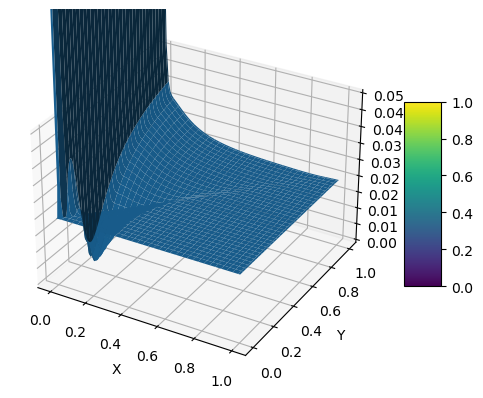

In [477]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = plt.axes(projection='3d')

# Make data.
X = xs#[20:30]
Y = ys#[20:30]
X, Y = np.meshgrid(X, Y)
#R = np.sqrt(X**2 + Y**2)
Z = (zs / zs.max())#[20:30,20:30]

# Plot the surface.
surf = ax.plot_surface(X, Y, Z,
                       linewidth=0, antialiased=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# Customize the z axis.
ax.set_zlim(0, 0.05)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [498]:
result = least_squares(fitness_LS, logit(np.random.random((2,))), method='lm')
print(expit(result.x))
result

[3.88632139e-62 2.00683337e-87]


     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 0.000e+00  4.372e-01 ... -1.996e+00 -1.996e+00]
           x: [-1.414e+02 -1.996e+02]
        cost: 11229723.59413503
         jac: [[ 0.000e+00  0.000e+00]
               [ 0.000e+00  0.000e+00]
               ...
               [ 0.000e+00  0.000e+00]
               [ 0.000e+00  0.000e+00]]
        grad: [ 0.000e+00  0.000e+00]
  optimality: 0.0
 active_mask: [0 0]
        nfev: 6
        njev: None

In [490]:
print( zs[91,91])

74916.57874708486
